In [1]:
#!pip install gym
#!pip install tensorflow
#!pip install pyglet
#!pip install keras
#!pip install tf-agents

#!pip install reverb

In [2]:
import tensorflow as tf
tf.__version__

'2.9.2'

### Import gym library

In [3]:
import gym
import random
import numpy as np

In [4]:
env_name = 'CartPole-v0'

In [5]:
env = gym.make(env_name)

### Reset the enviornment to its initial state and return 4 values in array

![Observation](obs.png)

In [6]:
obs = env.reset()
obs

array([ 0.00260033, -0.03472597, -0.04944156, -0.00430254], dtype=float32)

### observation_space returns the information about the environment space
    # Box data type i.e. for continous observation
    # returned Box object represents
    # Box([[lower range of obs], [upper range obs], (number of dimensions), data type])
![](env.png)

In [7]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

### action_space returns the Discrete object
### sequence of integers, reprents the actions

![](action.png)

In [8]:
env.action_space

Discrete(2)

In [9]:
#env.render()

### Termination state is reached when one of these conditions are met
### and done parameter is set to True

![](eps.png)

### Here a simple demonstartion of pushing cart to one side
### To run the cell below change cell's type from Raw to Code

### To take an action we need step() function
    # step function returns 4 parameters
    # [[obs state], reward, terminal state(done = bool),info]

### Importing the tensorflow environments
    # they generate tensors
    # and replay buffer can be used to train the agent

In [10]:
import tensorflow as tf
from tf_agents.environments import tf_py_environment
from tf_agents.environments import suite_gym

### Running a test for average score using random actions over 100 episodes

In [11]:
env = suite_gym.load(env_name)
tf_env = tf_py_environment.TFPyEnvironment(env)

time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 100

for _ in range(num_episodes):
    episode_reward = 0
    episode_steps = 0
    while not time_step.is_last():
        action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
        #print(action)
        time_step = tf_env.step(action)
        episode_steps += 1
        episode_reward += time_step.reward.numpy()
    rewards.append(episode_reward)
    steps.append(episode_steps)
    time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

print('num_episodes:', num_episodes, 'num_steps:', num_steps)
print('avg_length', avg_length, 'avg_reward:', avg_reward)

num_episodes: 100 num_steps: 2242
avg_length 22.42 avg_reward: 22.42


### Importing Q Policy libraries for creating a Q network for policies
    # Agents trained will be based on Deep Q-Learning network (DQN)
    # Q is quality of given moves
    # It Predicts Q value for each discrete action Q: State * Action --> Reward.
    # Bellman equation is a detailed explanation of this algorithm
![](bellman.svg)

In [12]:
from tf_agents.specs import tensor_spec
from tf_agents.networks import network
from tf_agents.policies import q_policy
from tf_agents.trajectories import time_step as ts

In [13]:
input_tensor_spec = tensor_spec.TensorSpec((4,), tf.float32)
time_step_spec = ts.time_step_spec(input_tensor_spec)
action_spec = tensor_spec.BoundedTensorSpec((),
                                            tf.int32,
                                            minimum=0,
                                            maximum=1)

num_actions = action_spec.maximum - action_spec.minimum + 1
print(action_spec, "\n\n Number of actions: \t", num_actions)

BoundedTensorSpec(shape=(), dtype=tf.int32, name=None, minimum=array(0, dtype=int32), maximum=array(1, dtype=int32)) 

 Number of actions: 	 2


In [14]:
class QNetwork(network.Network):

    def __init__(self, input_tensor_spec, action_spec, num_actions=num_actions, name=None):
        super(QNetwork, self).__init__(
            input_tensor_spec=input_tensor_spec,
            state_spec=(),
            name=name)
        self._sub_layers = [
            tf.keras.layers.Dense(num_actions),
        ]

    def call(self, inputs, step_type=None, network_state=()):
        del step_type
        inputs = tf.cast(inputs, tf.float32)
        for layer in self._sub_layers:
            inputs = layer(inputs)
        return inputs, network_state


batch_size = 2
observation = tf.ones([batch_size] + time_step_spec.observation.shape.as_list())
time_steps = ts.restart(observation, batch_size=batch_size)

my_q_network = QNetwork(
    input_tensor_spec=input_tensor_spec,
    action_spec=action_spec)

my_q_policy = q_policy.QPolicy(
    time_step_spec, action_spec, q_network=my_q_network)

action_step = my_q_policy.action(time_steps)
distribution_step = my_q_policy.distribution(time_steps)

print('Action:')
print(action_step.action)

print('Action distribution:')
print(distribution_step.action)

Action:
tf.Tensor([1 0], shape=(2,), dtype=int32)
Action distribution:
tfp.distributions.Categorical("Categorical", batch_shape=[2], event_shape=[], dtype=int32)


### Importing TensorFlow Drivers
    # There are 2 types of drivers
    # DynamicStepDriver, which terminates after a given number of (valid) environment steps
    # DynamicEpisodeDriver, which terminates after a given number of episodes

In [15]:
from tf_agents.metrics import tf_metrics
from tf_agents.drivers import dynamic_episode_driver

In [16]:
num_episodes = tf_metrics.NumberOfEpisodes()
env_steps = tf_metrics.EnvironmentSteps()
observers = [num_episodes, env_steps]

driver = dynamic_episode_driver.DynamicEpisodeDriver(
    tf_env, my_q_policy, observers, num_episodes=100)

# Initial driver.run will reset the environment and initialize the policy.
final_time_step, policy_state = driver.run()

print('final_time_step', final_time_step)
print('Number of Steps: ', env_steps.result().numpy())
print('Number of Episodes: ', num_episodes.result().numpy())
print('policy_state', policy_state)

final_time_step TimeStep(
{'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
 'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.02673768, -0.02472047,  0.01095815, -0.0441931 ]],
      dtype=float32)>,
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})
Number of Steps:  4807
Number of Episodes:  100
policy_state ()


### Importing Replay Buffers
    # replay buffers are used to store trajectories of experience when executing a policy in an environment.

In [17]:
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import dynamic_step_driver

In [18]:
q_net = q_network.QNetwork(
    tf_env.time_step_spec().observation,
    tf_env.action_spec(),
    fc_layer_params=(100,))

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=tf.compat.v1.train.AdamOptimizer(0.001))

replay_buffer_capacity = 1000

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_capacity)

# Add an observer that adds to the replay buffer:
replay_observer = [replay_buffer.add_batch]

collect_steps_per_iteration = 10
collect_op = dynamic_step_driver.DynamicStepDriver(
  tf_env,
  agent.collect_policy,
  observers=replay_observer,
  num_steps=collect_steps_per_iteration).run()

In [19]:
collect_op

(TimeStep(
 {'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
  'observation': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=
 array([[-0.05139242, -0.02753681,  0.03577055,  0.01794845]],
       dtype=float32)>,
  'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>}),
 ())

## Above all cells where the basic idea of building a network and training an agent, Now we proceed by putting all together from tensorflow documentations

### Importing libraries for training the DQN C51

In [20]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import categorical_q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common


#### Set hyperparameters

In [43]:
env_name = "CartPole-v0" # @param {type:"string"}
num_iterations = 15000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

fc_layer_params = (100,)

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
gamma = 0.99
log_interval = 200  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [44]:
env = suite_gym.load(env_name)

In [45]:
env.reset()
#PIL.Image.fromarray(env.render())


TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.02556861, -0.03434043, -0.02994688, -0.02370907], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In [24]:
#env.close()

In [46]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [47]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [48]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [49]:
time_step = env.reset()
print('Time step:',)
print(time_step, end="\n\n")

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.02121742,  0.03536892, -0.02512419,  0.02849847], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.0219248 ,  0.230842  , -0.02455422, -0.27200434], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


In [51]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [52]:
categorical_q_net = categorical_q_network.CategoricalQNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)

In [53]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    min_q_value=min_q_value,
    max_q_value=max_q_value,
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    train_step_counter=train_step_counter)
agent.initialize()

In [54]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

#### Method to compute the average returns

In [55]:
def compute_avg_return(environment, policy, num_episodes=10):

    total_return = 0.0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():

            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

initial_avg = compute_avg_return(eval_env, random_policy, num_eval_episodes)
print("Initial return avg: ",initial_avg)

Initial return avg:  23.4


### Data collection

In [56]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

def collect_step(environment, policy):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)

    # Add trajectory to the replay buffer
    replay_buffer.add_batch(traj)

for _ in range(initial_collect_steps):
    collect_step(train_env, random_policy)

# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(3)

iterator = iter(dataset)

In [57]:
iterator.element_spec

(Trajectory(
 {'action': TensorSpec(shape=(64, 3), dtype=tf.int64, name=None),
  'discount': TensorSpec(shape=(64, 3), dtype=tf.float32, name=None),
  'next_step_type': TensorSpec(shape=(64, 3), dtype=tf.int32, name=None),
  'observation': TensorSpec(shape=(64, 3, 4), dtype=tf.float32, name=None),
  'policy_info': (),
  'reward': TensorSpec(shape=(64, 3), dtype=tf.float32, name=None),
  'step_type': TensorSpec(shape=(64, 3), dtype=tf.int32, name=None)}),
 BufferInfo(ids=TensorSpec(shape=(64, 3), dtype=tf.int64, name=None), probabilities=TensorSpec(shape=(64,), dtype=tf.float32, name=None)))

#### Training the agent

In [58]:


# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience)

    step = agent.train_step_counter.numpy()
        

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1:.2f}'.format(step, avg_return))
        returns.append(avg_return)

step = 200: loss = 3.033783197402954
step = 400: loss = 2.4397497177124023
step = 600: loss = 2.207005023956299
step = 800: loss = 1.773998737335205
step = 1000: loss = 1.5341060161590576
step = 1000: Average Return = 50.70
step = 1200: loss = 1.4539989233016968
step = 1400: loss = 1.9140024185180664
step = 1600: loss = 1.4026364088058472
step = 1800: loss = 1.4463140964508057
step = 2000: loss = 1.1912596225738525
step = 2000: Average Return = 55.40
step = 2200: loss = 1.3010103702545166
step = 2400: loss = 1.361764907836914
step = 2600: loss = 1.3198384046554565
step = 2800: loss = 1.1071730852127075
step = 3000: loss = 1.199534296989441
step = 3000: Average Return = 107.40
step = 3200: loss = 1.030282735824585
step = 3400: loss = 0.7129906415939331
step = 3600: loss = 1.1632516384124756
step = 3800: loss = 1.090057134628296
step = 4000: loss = 0.821159839630127
step = 4000: Average Return = 96.30
step = 4200: loss = 0.8600460290908813
step = 4400: loss = 0.8259472250938416
step = 46

#### Plotting the output

(-0.5500000000000007, 200.0)

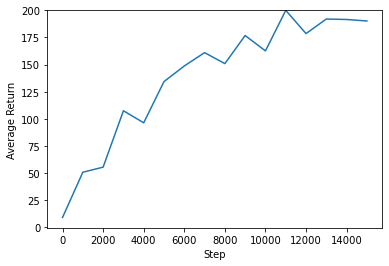

In [59]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim(top=200)

In [73]:
print(f"Comapring the| \nInitial average\t:\t{initial_avg} \nFinal average\t:\t{np.mean(returns)}")

Comapring the| 
Initial average	:	23.399999618530273 
Final average	:	137.84375
